In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables
inspector= inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station=Base.classes.station


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
data = pd.read_sql("SELECT date, prcp FROM measurement", conn)
grouped_prcp=data.groupby("date").mean()["prcp"]
grouped_prcp=pd.DataFrame(grouped_prcp)
# Calculate the date 1 year ago from the last data point in the database
grouped_prcp=grouped_prcp.tail(365).reset_index()
grouped_prcp

,date,prcp
0,2016-08-24,1.555000
1,2016-08-25,0.077143
2,2016-08-26,0.016667
3,2016-08-27,0.064000
4,2016-08-28,0.516667
...,...,...
360,2017-08-19,0.030000
361,2017-08-20,0.005000
362,2017-08-21,0.193333
363,2017-08-22,0.166667


Text(0, 0.5, 'Inches')

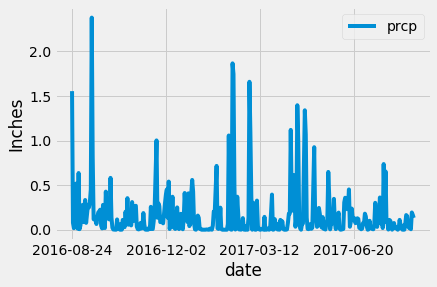

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
grouped_prcp.plot(x="date", y="prcp", figsize=(6,4))
plt.ylabel("Inches")
#plt.legend("Percipitation")

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
grouped_prcp["prcp"].describe().round(4)

count    365.0000
mean       0.1700
std        0.2957
min        0.0000
25%        0.0086
50%        0.0700
75%        0.1917
max        2.3800
Name: prcp, dtype: float64

In [13]:
# Design a query to show how many stations are available in this dataset?
no_of_stations=session.query(Station).count()
no_of_stations

9

In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_station=session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
# List the stations and the counts in descending order.
for row in active_station:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active =session.query(func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
            filter_by(station="USC00519281")
for temp in most_active:
    print(temp)

(54.0, 85.0, 71.66378066378067)


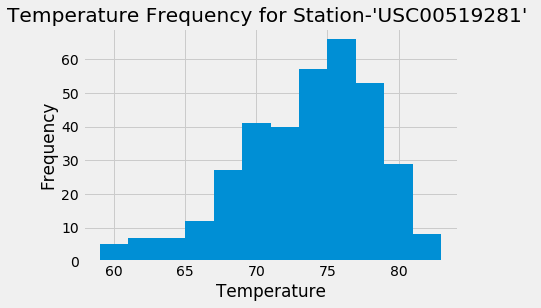

In [16]:
# Choose the station with the highest number of temperature observations.
temp = session.query(Measurement.date, Measurement.tobs).filter_by(station="USC00519281").filter(Measurement.date > '2016-08-22')
tobs= [row[1] for row in temp]
#Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.hist(tobs, bins=12)
plt.title("Temperature Frequency for Station-'USC00519281' ")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp= calc_temps("2017-07-24", "2017-08-01")
temp

[(72.0, 78.66071428571429, 84.0)]

Text(0.5, 1.0, 'Average Trip Temperature')

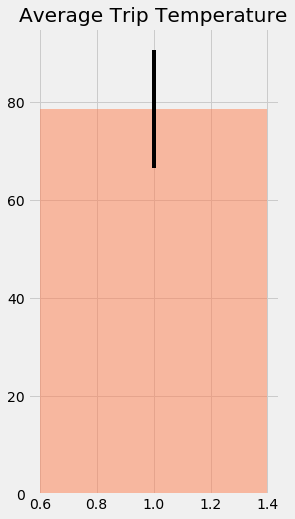

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# plt.bar()
fig,ax=plt.subplots(figsize=plt.figaspect(2))
xpos=1
yerr=temp[0][2]-temp[0][0]
bar=ax.bar(xpos,temp[0][1],yerr=yerr,alpha=0.5,color='coral',align='center')
plt.title("Average Trip Temperature")

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
rainfall= session.query(Measurement.station, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation ).filter(Measurement.date >="2017-07-24").\
filter(Measurement.date <="2017-08-01" ).group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
rainfall
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
df=pd.DataFrame(rainfall, columns=["Station", "Total_prcp", "Latitude", "Longitude", "Elevation"])
df

,Station,Total_prcp,Latitude,Longitude,Elevation
0,USC00516128,21.96,21.2716,-157.8168,3.0
1,USC00514830,14.49,21.2716,-157.8168,3.0
2,USC00519281,10.53,21.2716,-157.8168,3.0
3,USC00513117,7.74,21.2716,-157.8168,3.0
4,USC00519397,0.63,21.2716,-157.8168,3.0
5,USC00519523,0.45,21.2716,-157.8168,3.0
6,USC00517948,0.09,21.2716,-157.8168,3.0


In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
dates=["07-24", "07-25", "07-26","07-27", "07-28","07-29","07-30", "07-31", "08-01"]
normals=[]
for date in dates:
    result=daily_normals(date)[0]
    normals.append(result)
normals

[(69.0, 76.55555555555556, 81.0),
 (67.0, 76.89090909090909, 84.0),
 (71.0, 76.4423076923077, 86.0),
 (68.0, 76.58181818181818, 83.0),
 (69.0, 76.46428571428571, 82.0),
 (69.0, 76.47058823529412, 83.0),
 (69.0, 77.35185185185185, 84.0),
 (72.0, 77.03571428571429, 83.0),
 (67.0, 75.54, 83.0)]

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df=pd.DataFrame(normals, columns=["TMIN", "TAVG", "TMAX"], index=dates)
df

,TMIN,TAVG,TMAX
07-24,69.0,76.555556,81.0
07-25,67.0,76.890909,84.0
07-26,71.0,76.442308,86.0
07-27,68.0,76.581818,83.0
07-28,69.0,76.464286,82.0
07-29,69.0,76.470588,83.0
07-30,69.0,77.351852,84.0
07-31,72.0,77.035714,83.0
08-01,67.0,75.540000,83.0


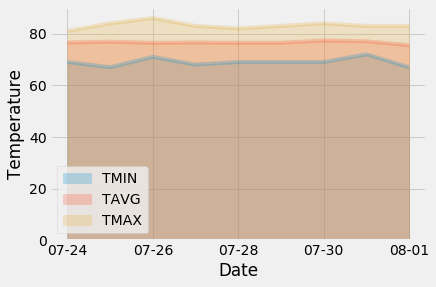

In [24]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind="area", stacked=False, alpha=0.25)
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.show()